In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import io
import os
import glob

folder_path = r'C:\Users\Admin\Documents\trajectory with velocities' 
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
csv_files.sort()
dataframes = [pd.read_csv(file) for file in csv_files[:7]]

merged_df = pd.concat(dataframes, ignore_index=True)
merged_df.to_csv('merged.csv', index=False)
print(" Merged file saved as 'merged.csv'")



 Merged file saved as 'merged.csv'


In [3]:
# Loading CSV file
df = pd.read_csv('merged.csv')

dt = 1 / 50  # 50Hz
df['delta_x_v'] = df['ins_vel_hor_x'] * dt
df['delta_y_v'] = df['ins_vel_hor_y'] * dt
print("Deltas calculated.")

seq_len = 75

# Input and target columns
input_columns = ['SW_pos_obd', 'brake_pressure_obd', 'LatAcc_obd', 'speedo_obd',
                 'VelFR_obd', 'VelFL_obd', 'VelRR_obd', 'VelRL_obd', 'Yawrate_obd', 'ins_yaw']
target_columns = ['ins_vel_hor_x', 'ins_vel_hor_y', 'delta_x_v', 'delta_y_v']

# Split dataset
train_size = int(0.7 * len(df))
val_size = int(0.1 * len(df))
test_size = len(df) - train_size - val_size

train_data = df[:train_size]
val_data = df[train_size:train_size + val_size]
test_data = df[train_size + val_size:]

# Scaling inputs and targets
input_scaler = StandardScaler().fit(train_data[input_columns].values)
target_scaler = StandardScaler().fit(train_data[target_columns].values)
print("Data split and scaled.")

# Dataset class
class SingleStepDataset(Dataset):
    def __init__(self, data, input_columns, target_columns, seq_len, input_scaler, target_scaler):
        self.seq_len = seq_len
        inputs = data[input_columns].values
        targets = data[target_columns].values
        self.inputs = input_scaler.transform(inputs)
        self.targets = target_scaler.transform(targets)

    def __len__(self):
        return len(self.inputs) - self.seq_len

    def __getitem__(self, idx):
        x = self.inputs[idx : idx + self.seq_len]
        y = self.targets[idx + self.seq_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

train_dataset = SingleStepDataset(train_data, input_columns, target_columns, seq_len, input_scaler, target_scaler)
val_dataset = SingleStepDataset(val_data, input_columns, target_columns, seq_len, input_scaler, target_scaler)
test_dataset = SingleStepDataset(test_data, input_columns, target_columns, seq_len, input_scaler, target_scaler)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("Data loaded into DataLoaders.")

# LSTM model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out
    
# Hyperparameters
input_size = len(input_columns)
hidden_size = 64
num_layers = 3
output_size = len(target_columns)
dropout = 0.2
learning_rate = 0.0005
weight_decay = 1e-5
epochs = 50
patience = 10

# Initialize model, loss, optimizer
model = LSTMRegressor(input_size, hidden_size, num_layers, output_size, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
best_val_loss = np.inf
early_stopping_counter = 0
print("Model initialized.")

Deltas calculated.
Data split and scaled.
Data loaded into DataLoaders.
Model initialized.


In [5]:
# Training loop
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch, y_batch
        optimizer.zero_grad()
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val, y_val
            predictions = model(x_val)
            loss = criterion(predictions, y_val)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Best model saved at epoch {epoch+1}.")
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/50 - Train Loss: 0.0739, Val Loss: 0.0131
Best model saved at epoch 1.
Epoch 2/50 - Train Loss: 0.0609, Val Loss: 0.0141
Epoch 3/50 - Train Loss: 0.0552, Val Loss: 0.0201
Epoch 4/50 - Train Loss: 0.0506, Val Loss: 0.0193
Epoch 5/50 - Train Loss: 0.0453, Val Loss: 0.0081
Best model saved at epoch 5.
Epoch 6/50 - Train Loss: 0.0432, Val Loss: 0.0086
Epoch 7/50 - Train Loss: 0.0408, Val Loss: 0.0102
Epoch 8/50 - Train Loss: 0.0391, Val Loss: 0.0097
Epoch 9/50 - Train Loss: 0.0381, Val Loss: 0.0078
Best model saved at epoch 9.
Epoch 10/50 - Train Loss: 0.0367, Val Loss: 0.0093
Epoch 11/50 - Train Loss: 0.0346, Val Loss: 0.0106
Epoch 12/50 - Train Loss: 0.0332, Val Loss: 0.0098
Epoch 13/50 - Train Loss: 0.0320, Val Loss: 0.0094
Epoch 14/50 - Train Loss: 0.0301, Val Loss: 0.0084
Epoch 15/50 - Train Loss: 0.0291, Val Loss: 0.0102
Epoch 16/50 - Train Loss: 0.0287, Val Loss: 0.0087
Epoch 17/50 - Train Loss: 0.0272, Val Loss: 0.0105
Epoch 18/50 - Train Loss: 0.0276, Val Loss: 0.0118
Epoc

In [7]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
print("Best model loaded.")

# Predictions
preds, targets = [], []
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test
        pred = model(x_test).cpu().numpy()
        preds.append(pred)
        targets.append(y_test.numpy())
preds = np.concatenate(preds, axis=0)
targets = np.concatenate(targets, axis=0)
preds_unscaled = target_scaler.inverse_transform(preds)
targets_unscaled = target_scaler.inverse_transform(targets)

Best model loaded.



--- ins_vel_hor_x ---
MSE : 0.0231
RMSE: 0.1519
MAE : 0.0924
R²  : 0.9973


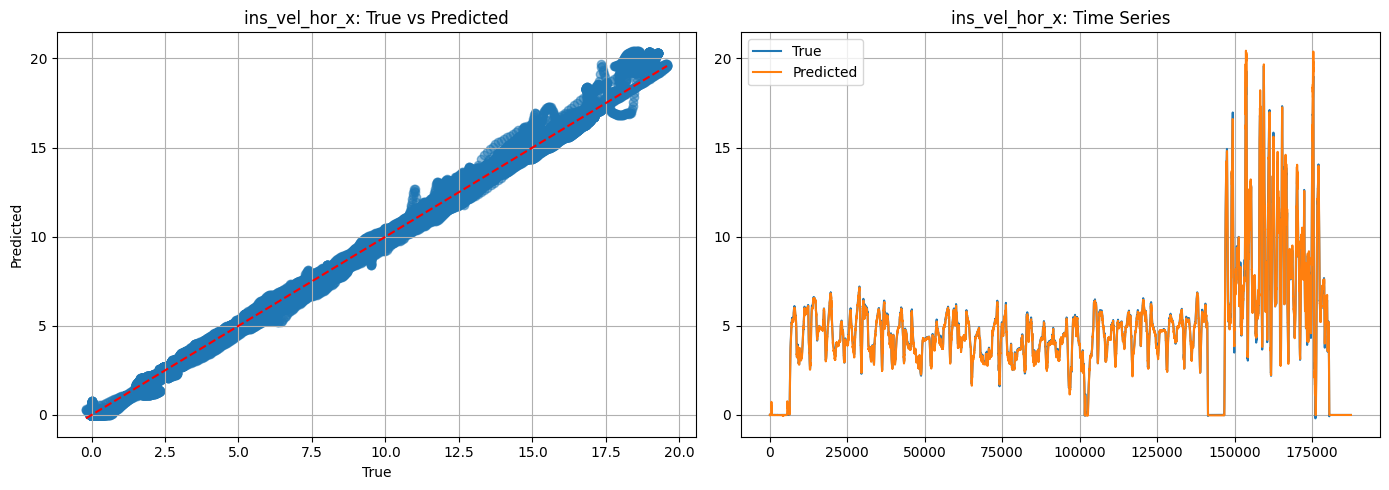


--- ins_vel_hor_y ---
MSE : 0.0010
RMSE: 0.0314
MAE : 0.0110
R²  : 0.9102


<Figure size 640x480 with 0 Axes>

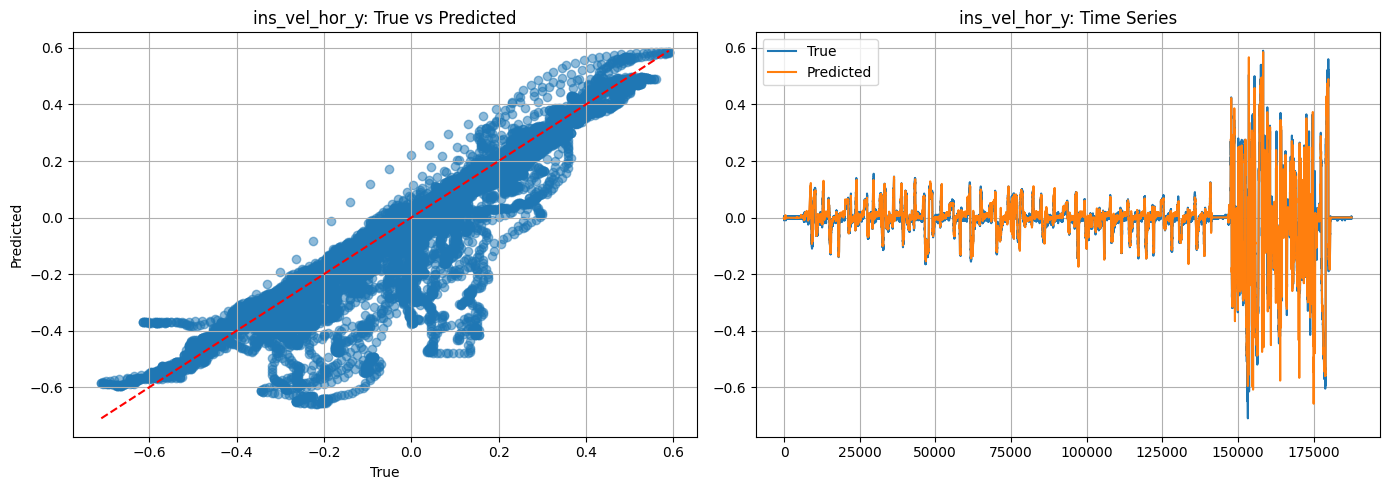


--- delta_x_v ---
MSE : 0.0000
RMSE: 0.0030
MAE : 0.0019
R²  : 0.9972


<Figure size 640x480 with 0 Axes>

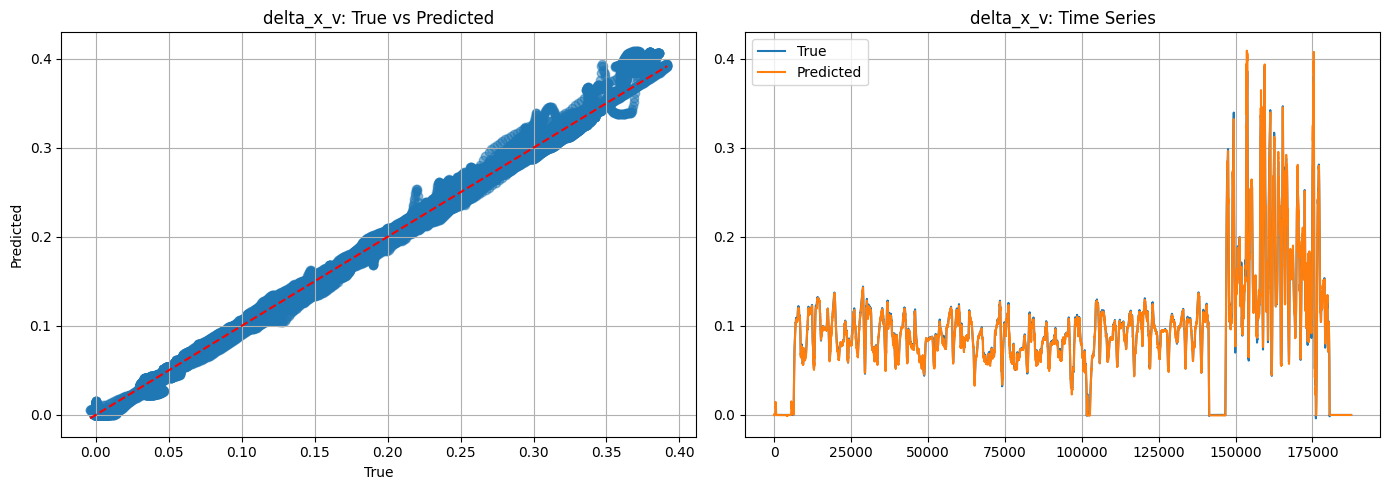


--- delta_y_v ---
MSE : 0.0000
RMSE: 0.0006
MAE : 0.0002
R²  : 0.9100


<Figure size 640x480 with 0 Axes>

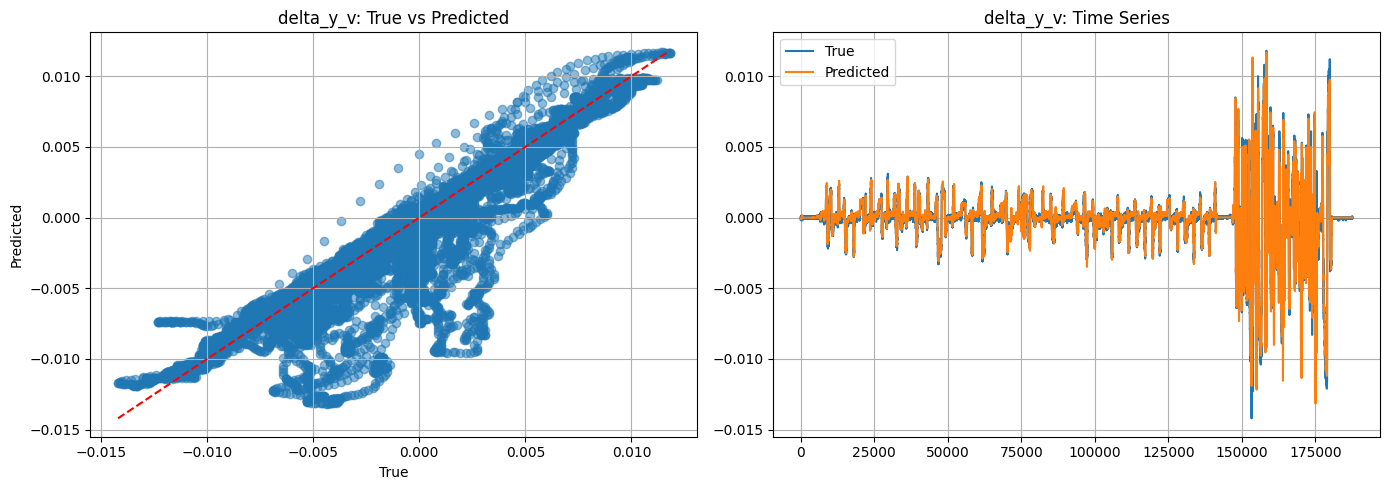

<Figure size 640x480 with 0 Axes>

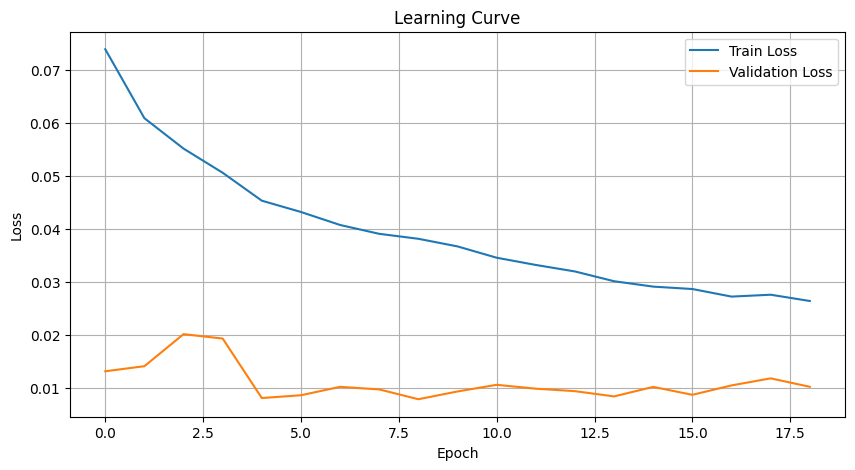

<Figure size 640x480 with 0 Axes>

In [23]:
# Metrics and plots
metrics = {}
for i, name in enumerate(target_columns):
    y_true = targets_unscaled[:, i]
    y_pred = preds_unscaled[:, i]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    metrics[name] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

    print(f"\n--- {name} ---")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    axes[0].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    axes[0].set_title(f'{name}: True vs Predicted')
    axes[0].set_xlabel('True')
    axes[0].set_ylabel('Predicted')
    axes[0].grid(True)

    axes[1].plot(y_true, label='True')
    axes[1].plot(y_pred, label='Predicted')
    axes[1].set_title(f'{name}: Time Series')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
    plt.savefig(f"predictions.png")

# Learning curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig("Learning_Curve.png")

<Figure size 1000x800 with 0 Axes>

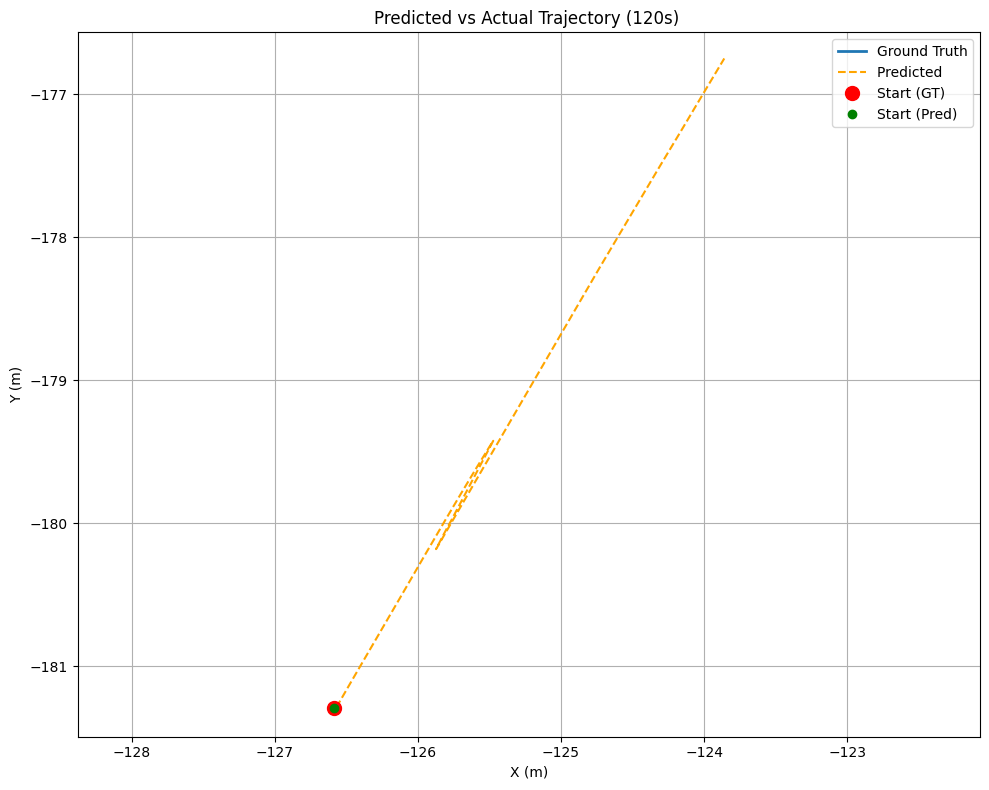

<Figure size 640x480 with 0 Axes>

In [28]:
# Trajectory reconstruction for the first x seconds of the test set
num_timesteps = 120 * 50 #accurately first at 150 till 290 

yaw_segment = df['ins_yaw'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]
yaw_segment = -np.deg2rad(yaw_segment) # Ensure the yaw is in radians and potentially negated based on your coordinate system

pred_dx_v_segment = preds_unscaled[:num_timesteps, 2]
pred_dy_v_segment = preds_unscaled[:num_timesteps, 3]

# Rotate deltas to the fixed frame for the segment
delta_x_f_segment = pred_dx_v_segment * np.cos(yaw_segment) - pred_dy_v_segment * np.sin(yaw_segment)
delta_y_f_segment = pred_dx_v_segment * np.sin(yaw_segment) + pred_dy_v_segment * np.cos(yaw_segment) # Corrected sin angle

# Get the starting point of the test set
start_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size]
start_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size]

# Calculate predicted trajectory for the segment
pred_pos_x_segment = np.cumsum(delta_x_f_segment) + start_x
pred_pos_y_segment = np.cumsum(delta_y_f_segment) + start_y

# Get ground truth trajectory for the segment
gt_pos_x_segment = df['ins_pos_rel_x'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]
gt_pos_y_segment = df['ins_pos_rel_y'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]

plt.figure(figsize=(10, 8))


plt.figure(figsize=(10, 8))
plt.plot(gt_pos_x_segment, gt_pos_y_segment, label='Ground Truth', linewidth=2)
plt.plot(pred_pos_x_segment, pred_pos_y_segment, label='Predicted ', linestyle='--', color='orange')
plt.plot(gt_pos_x_segment[0], gt_pos_y_segment[0], 'ro', markersize=10, label='Start (GT)')
plt.plot(pred_pos_x_segment[0], pred_pos_y_segment[0], 'go', markersize=6, label='Start (Pred)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Predicted vs Actual Trajectory (120s) ')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()
plt.savefig("Trajectory 120s")

<Figure size 1000x800 with 0 Axes>

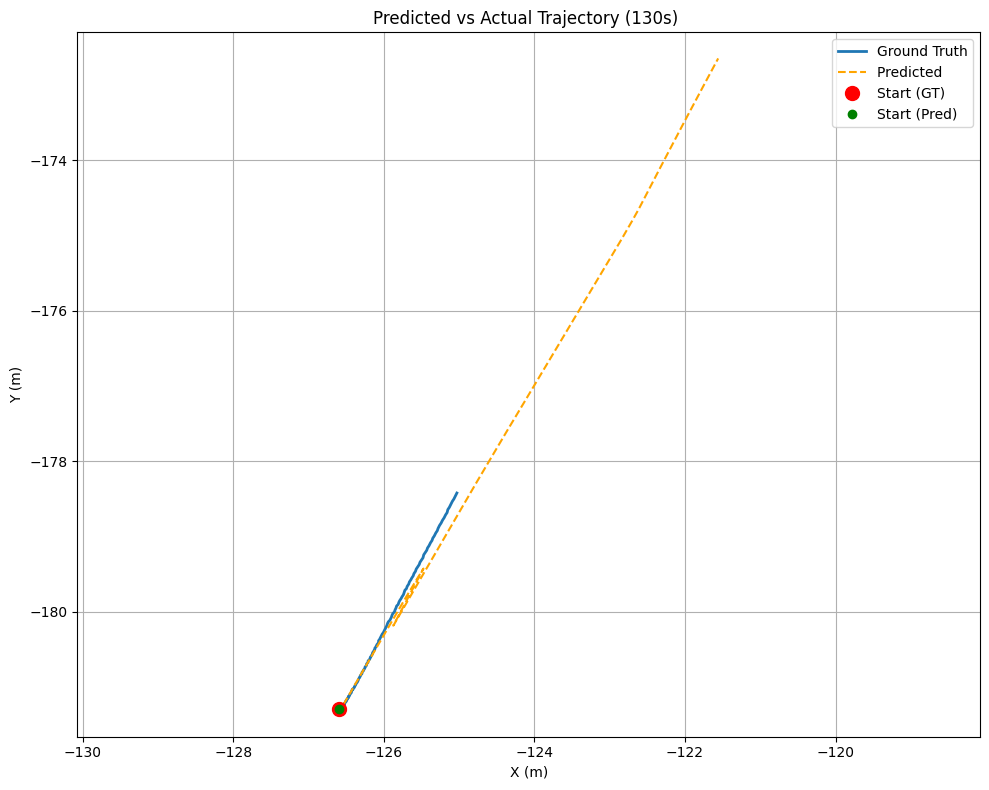

<Figure size 640x480 with 0 Axes>

In [ ]:
# Trajectory reconstruction for the first x seconds of the test set
num_timesteps = 130 * 50 #starts at 130 till 290 

yaw_segment = df['ins_yaw'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]
yaw_segment = -np.deg2rad(yaw_segment) # Ensure the yaw is in radians and potentially negated based on your coordinate system

pred_dx_v_segment = preds_unscaled[:num_timesteps, 2]
pred_dy_v_segment = preds_unscaled[:num_timesteps, 3]

# Rotate deltas to the fixed frame for the segment
delta_x_f_segment = pred_dx_v_segment * np.cos(yaw_segment) - pred_dy_v_segment * np.sin(yaw_segment)
delta_y_f_segment = pred_dx_v_segment * np.sin(yaw_segment) + pred_dy_v_segment * np.cos(yaw_segment) # Corrected sin angle

# Get the starting point of the test set
start_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size]
start_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size]

# Calculate predicted trajectory for the segment
pred_pos_x_segment = np.cumsum(delta_x_f_segment) + start_x
pred_pos_y_segment = np.cumsum(delta_y_f_segment) + start_y

# Get ground truth trajectory for the segment
gt_pos_x_segment = df['ins_pos_rel_x'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]
gt_pos_y_segment = df['ins_pos_rel_y'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]

plt.figure(figsize=(10, 8))


plt.figure(figsize=(10, 8))
plt.plot(gt_pos_x_segment, gt_pos_y_segment, label='Ground Truth', linewidth=2)
plt.plot(pred_pos_x_segment, pred_pos_y_segment, label='Predicted ', linestyle='--', color='orange')
plt.plot(gt_pos_x_segment[0], gt_pos_y_segment[0], 'ro', markersize=10, label='Start (GT)')
plt.plot(pred_pos_x_segment[0], pred_pos_y_segment[0], 'go', markersize=6, label='Start (Pred)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Predicted vs Actual Trajectory (130s) ')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()
plt.savefig("Trajectory_start 130s")

<Figure size 1000x800 with 0 Axes>

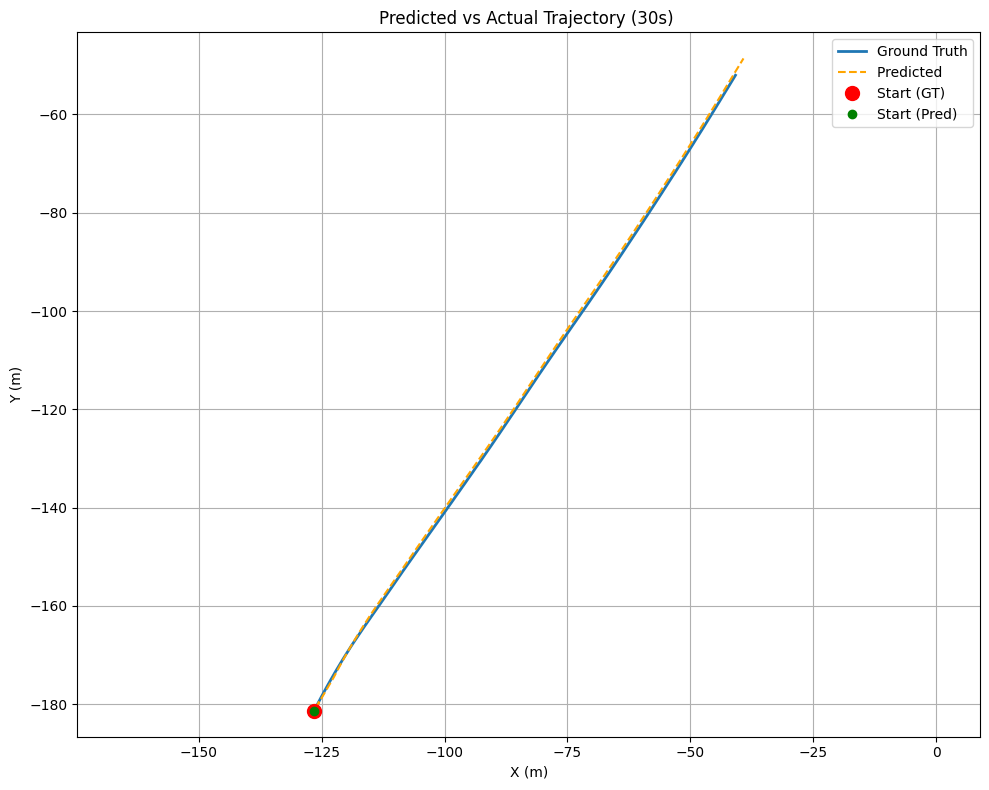

<Figure size 640x480 with 0 Axes>

In [27]:
# Trajectory reconstruction for the first x seconds of the test set
num_timesteps = 160 * 50 #accurately first at 150 till 290 

yaw_segment = df['ins_yaw'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]
yaw_segment = -np.deg2rad(yaw_segment) # Ensure the yaw is in radians and potentially negated based on your coordinate system

pred_dx_v_segment = preds_unscaled[:num_timesteps, 2]
pred_dy_v_segment = preds_unscaled[:num_timesteps, 3]

# Rotate deltas to the fixed frame for the segment
delta_x_f_segment = pred_dx_v_segment * np.cos(yaw_segment) - pred_dy_v_segment * np.sin(yaw_segment)
delta_y_f_segment = pred_dx_v_segment * np.sin(yaw_segment) + pred_dy_v_segment * np.cos(yaw_segment) # Corrected sin angle

# Get the starting point of the test set
start_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size]
start_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size]

# Calculate predicted trajectory for the segment
pred_pos_x_segment = np.cumsum(delta_x_f_segment) + start_x
pred_pos_y_segment = np.cumsum(delta_y_f_segment) + start_y

# Get ground truth trajectory for the segment
gt_pos_x_segment = df['ins_pos_rel_x'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]
gt_pos_y_segment = df['ins_pos_rel_y'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]

plt.figure(figsize=(10, 8))


plt.figure(figsize=(10, 8))
plt.plot(gt_pos_x_segment, gt_pos_y_segment, label='Ground Truth', linewidth=2)
plt.plot(pred_pos_x_segment, pred_pos_y_segment, label='Predicted ', linestyle='--', color='orange')
plt.plot(gt_pos_x_segment[0], gt_pos_y_segment[0], 'ro', markersize=10, label='Start (GT)')
plt.plot(pred_pos_x_segment[0], pred_pos_y_segment[0], 'go', markersize=6, label='Start (Pred)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Predicted vs Actual Trajectory (30s) ')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()
plt.savefig("Trajectory_30s after start")

<Figure size 1000x800 with 0 Axes>

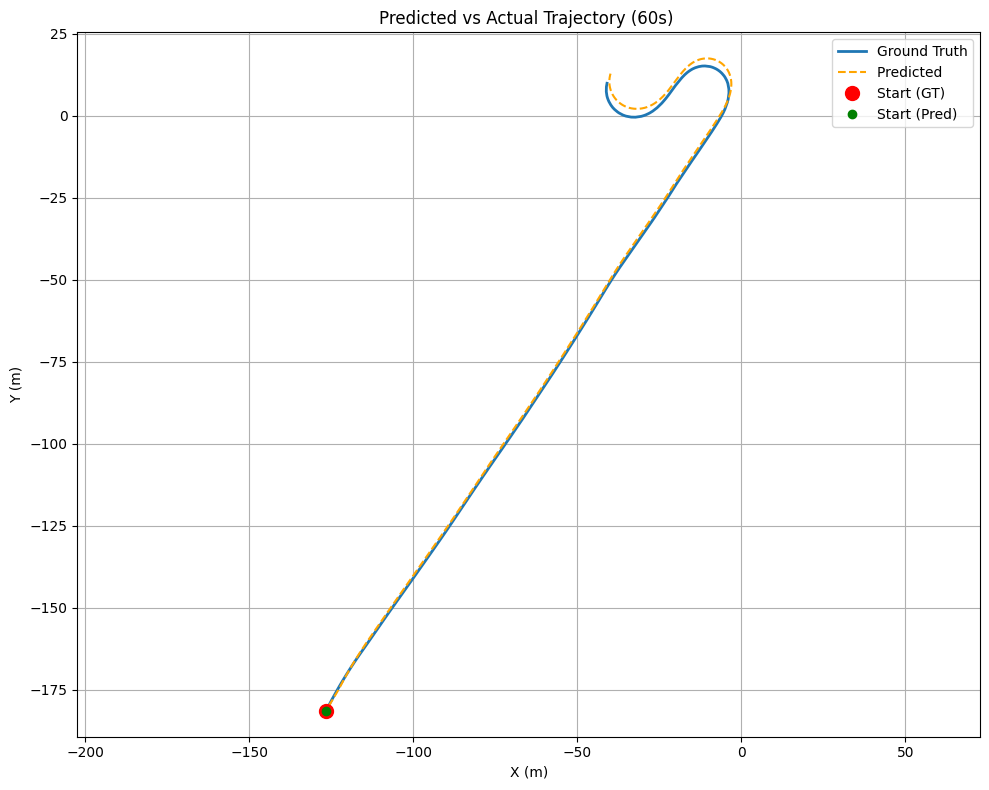

<Figure size 640x480 with 0 Axes>

In [45]:
# Trajectory reconstruction for the first x seconds of the test set
num_timesteps = 190 * 50 #accurately first at 150 till 290 

yaw_segment = df['ins_yaw'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]
yaw_segment = -np.deg2rad(yaw_segment) # Ensure the yaw is in radians and potentially negated based on your coordinate system

pred_dx_v_segment = preds_unscaled[:num_timesteps, 2]
pred_dy_v_segment = preds_unscaled[:num_timesteps, 3]

# Rotate deltas to the fixed frame for the segment
delta_x_f_segment = pred_dx_v_segment * np.cos(yaw_segment) - pred_dy_v_segment * np.sin(yaw_segment)
delta_y_f_segment = pred_dx_v_segment * np.sin(yaw_segment) + pred_dy_v_segment * np.cos(yaw_segment) # Corrected sin angle

# Get the starting point of the test set
start_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size]
start_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size]

# Calculate predicted trajectory for the segment
pred_pos_x_segment = np.cumsum(delta_x_f_segment) + start_x
pred_pos_y_segment = np.cumsum(delta_y_f_segment) + start_y

# Get ground truth trajectory for the segment
gt_pos_x_segment = df['ins_pos_rel_x'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]
gt_pos_y_segment = df['ins_pos_rel_y'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]

plt.figure(figsize=(10, 8))


plt.figure(figsize=(10, 8))
plt.plot(gt_pos_x_segment, gt_pos_y_segment, label='Ground Truth', linewidth=2)
plt.plot(pred_pos_x_segment, pred_pos_y_segment, label='Predicted ', linestyle='--', color='orange')
plt.plot(gt_pos_x_segment[0], gt_pos_y_segment[0], 'ro', markersize=10, label='Start (GT)')
plt.plot(pred_pos_x_segment[0], pred_pos_y_segment[0], 'go', markersize=6, label='Start (Pred)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Predicted vs Actual Trajectory (60s) ')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()
plt.savefig("Trajectory_60s after start")

<Figure size 1000x800 with 0 Axes>

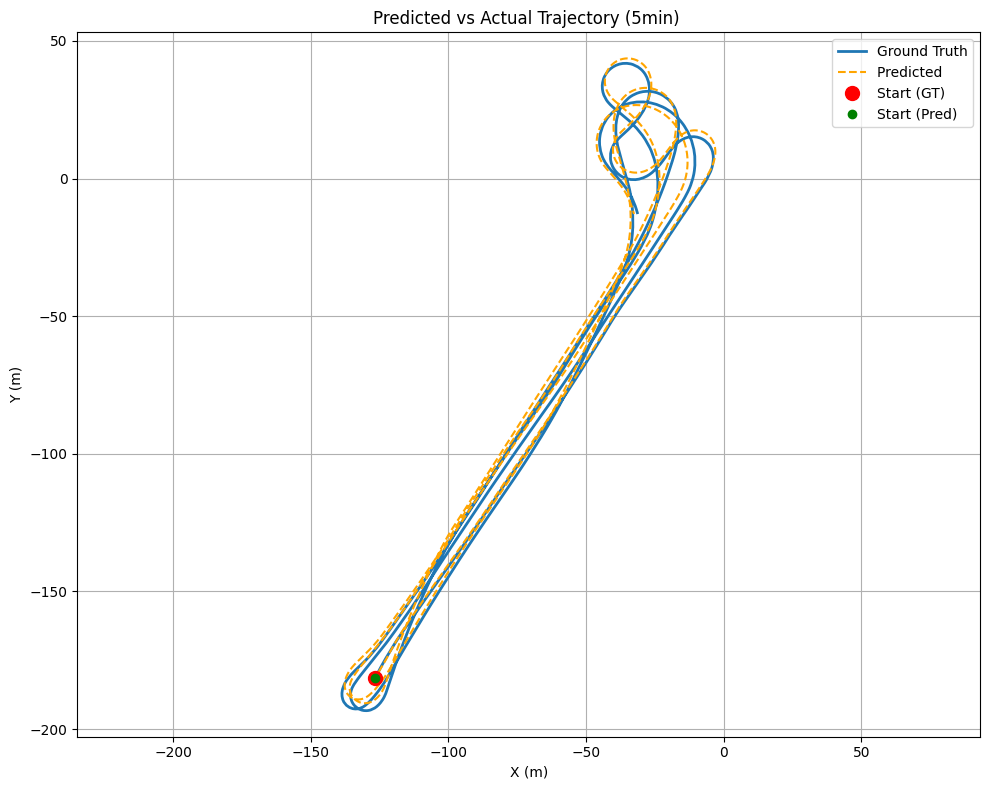

<Figure size 640x480 with 0 Axes>

In [43]:
# Trajectory reconstruction for the first x seconds of the test set
num_timesteps = 430 * 50 #accurately first at 150 till 290 

yaw_segment = df['ins_yaw'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]
yaw_segment = -np.deg2rad(yaw_segment) # Ensure the yaw is in radians and potentially negated based on your coordinate system

pred_dx_v_segment = preds_unscaled[:num_timesteps, 2]
pred_dy_v_segment = preds_unscaled[:num_timesteps, 3]

# Rotate deltas to the fixed frame for the segment
delta_x_f_segment = pred_dx_v_segment * np.cos(yaw_segment) - pred_dy_v_segment * np.sin(yaw_segment)
delta_y_f_segment = pred_dx_v_segment * np.sin(yaw_segment) + pred_dy_v_segment * np.cos(yaw_segment) # Corrected sin angle

# Get the starting point of the test set
start_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size]
start_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size]

# Calculate predicted trajectory for the segment
pred_pos_x_segment = np.cumsum(delta_x_f_segment) + start_x
pred_pos_y_segment = np.cumsum(delta_y_f_segment) + start_y

# Get ground truth trajectory for the segment
gt_pos_x_segment = df['ins_pos_rel_x'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]
gt_pos_y_segment = df['ins_pos_rel_y'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]

plt.figure(figsize=(10, 8))


plt.figure(figsize=(10, 8))
plt.plot(gt_pos_x_segment, gt_pos_y_segment, label='Ground Truth', linewidth=2)
plt.plot(pred_pos_x_segment, pred_pos_y_segment, label='Predicted ', linestyle='--', color='orange')
plt.plot(gt_pos_x_segment[0], gt_pos_y_segment[0], 'ro', markersize=10, label='Start (GT)')
plt.plot(pred_pos_x_segment[0], pred_pos_y_segment[0], 'go', markersize=6, label='Start (Pred)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Predicted vs Actual Trajectory (5min) ')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()
plt.savefig("Trajectory_5min after start")

<Figure size 1000x800 with 0 Axes>

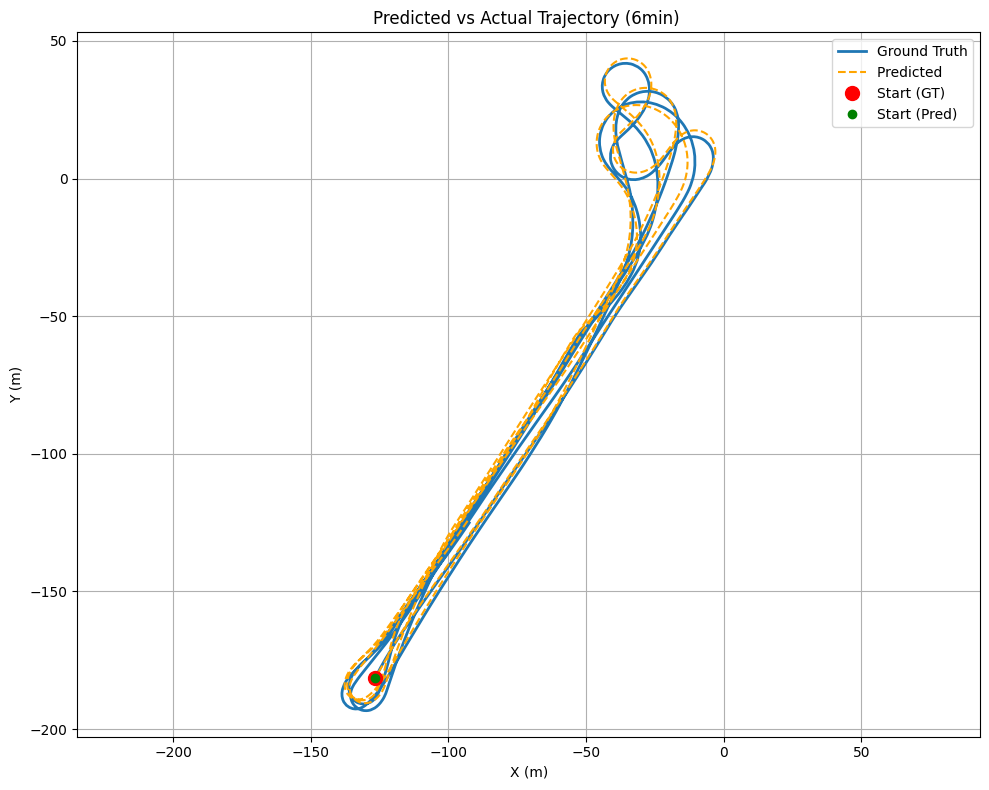

<Figure size 640x480 with 0 Axes>

In [47]:
# Trajectory reconstruction for the first x seconds of the test set
num_timesteps = 500 * 50 #accurately first at 150 till 290 

yaw_segment = df['ins_yaw'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]
yaw_segment = -np.deg2rad(yaw_segment) # Ensure the yaw is in radians and potentially negated based on your coordinate system

pred_dx_v_segment = preds_unscaled[:num_timesteps, 2]
pred_dy_v_segment = preds_unscaled[:num_timesteps, 3]

# Rotate deltas to the fixed frame for the segment
delta_x_f_segment = pred_dx_v_segment * np.cos(yaw_segment) - pred_dy_v_segment * np.sin(yaw_segment)
delta_y_f_segment = pred_dx_v_segment * np.sin(yaw_segment) + pred_dy_v_segment * np.cos(yaw_segment) # Corrected sin angle

# Get the starting point of the test set
start_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size]
start_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size]

# Calculate predicted trajectory for the segment
pred_pos_x_segment = np.cumsum(delta_x_f_segment) + start_x
pred_pos_y_segment = np.cumsum(delta_y_f_segment) + start_y

# Get ground truth trajectory for the segment
gt_pos_x_segment = df['ins_pos_rel_x'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]
gt_pos_y_segment = df['ins_pos_rel_y'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]

plt.figure(figsize=(10, 8))


plt.figure(figsize=(10, 8))
plt.plot(gt_pos_x_segment, gt_pos_y_segment, label='Ground Truth', linewidth=2)
plt.plot(pred_pos_x_segment, pred_pos_y_segment, label='Predicted ', linestyle='--', color='orange')
plt.plot(gt_pos_x_segment[0], gt_pos_y_segment[0], 'ro', markersize=10, label='Start (GT)')
plt.plot(pred_pos_x_segment[0], pred_pos_y_segment[0], 'go', markersize=6, label='Start (Pred)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Predicted vs Actual Trajectory (6min) ')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()
plt.savefig("Trajectory_6min after start")

<Figure size 1000x800 with 0 Axes>

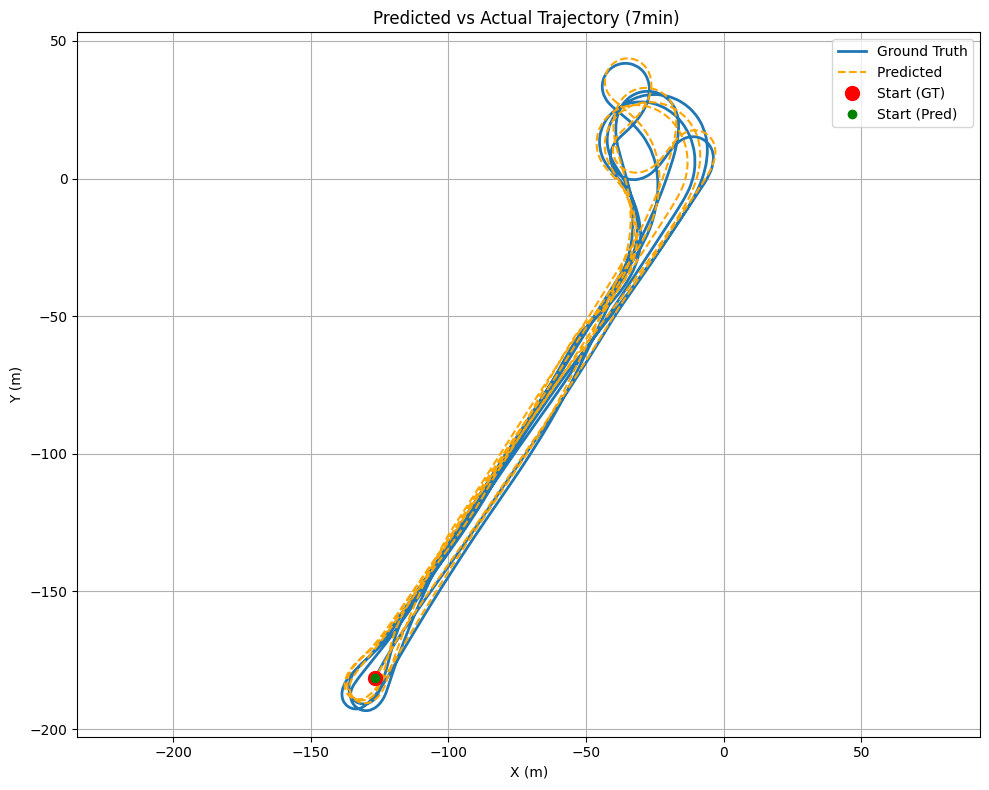

<Figure size 640x480 with 0 Axes>

In [48]:
# Trajectory reconstruction for the first x seconds of the test set
num_timesteps = 560 * 50 #accurately first at 150 till 290 

yaw_segment = df['ins_yaw'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]
yaw_segment = -np.deg2rad(yaw_segment) # Ensure the yaw is in radians and potentially negated based on your coordinate system

pred_dx_v_segment = preds_unscaled[:num_timesteps, 2]
pred_dy_v_segment = preds_unscaled[:num_timesteps, 3]

# Rotate deltas to the fixed frame for the segment
delta_x_f_segment = pred_dx_v_segment * np.cos(yaw_segment) - pred_dy_v_segment * np.sin(yaw_segment)
delta_y_f_segment = pred_dx_v_segment * np.sin(yaw_segment) + pred_dy_v_segment * np.cos(yaw_segment) # Corrected sin angle

# Get the starting point of the test set
start_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size]
start_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size]

# Calculate predicted trajectory for the segment
pred_pos_x_segment = np.cumsum(delta_x_f_segment) + start_x
pred_pos_y_segment = np.cumsum(delta_y_f_segment) + start_y

# Get ground truth trajectory for the segment
gt_pos_x_segment = df['ins_pos_rel_x'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]
gt_pos_y_segment = df['ins_pos_rel_y'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]

plt.figure(figsize=(10, 8))


plt.figure(figsize=(10, 8))
plt.plot(gt_pos_x_segment, gt_pos_y_segment, label='Ground Truth', linewidth=2)
plt.plot(pred_pos_x_segment, pred_pos_y_segment, label='Predicted ', linestyle='--', color='orange')
plt.plot(gt_pos_x_segment[0], gt_pos_y_segment[0], 'ro', markersize=10, label='Start (GT)')
plt.plot(pred_pos_x_segment[0], pred_pos_y_segment[0], 'go', markersize=6, label='Start (Pred)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Predicted vs Actual Trajectory (7min) ')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()
plt.savefig("Trajectory_7min after start")

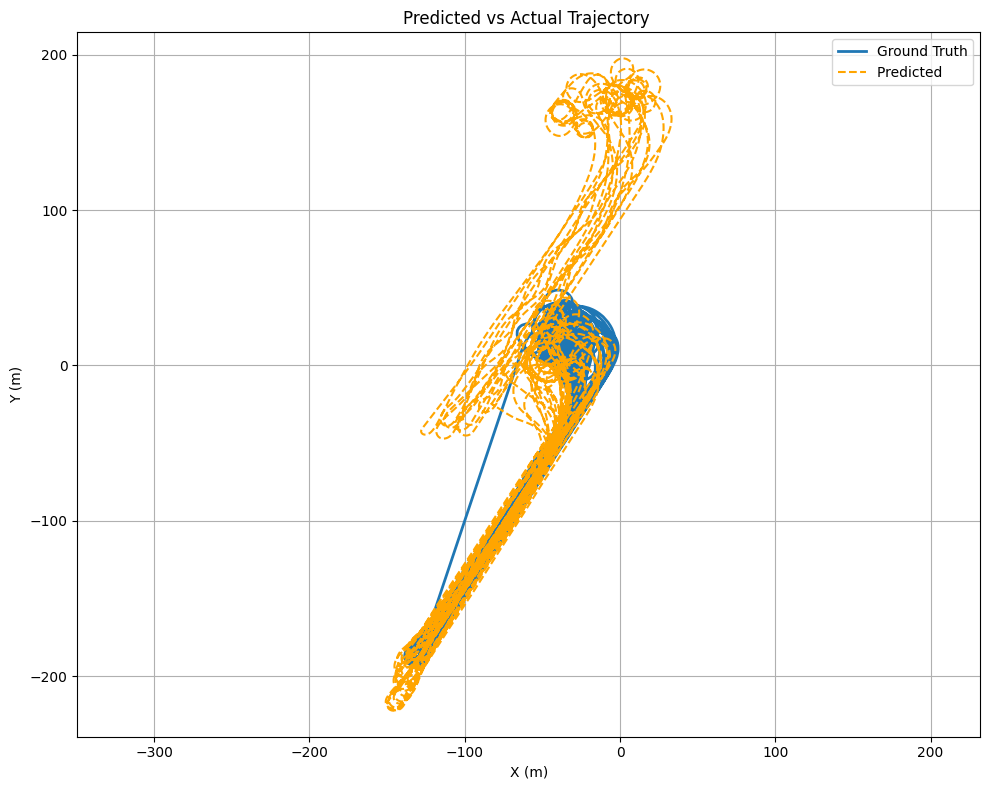

<Figure size 640x480 with 0 Axes>

In [49]:
# Trajectory reconstruction
yaw = df['ins_yaw'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + len(preds_unscaled)]
yaw = -np.deg2rad(yaw)

pred_dx_v = preds_unscaled[:, 2]
pred_dy_v = preds_unscaled[:, 3]

#converting to global frame
delta_x_f = pred_dx_v * np.cos(yaw) - pred_dy_v * np.sin(yaw)
delta_y_f = pred_dx_v * np.sin(yaw) + pred_dy_v * np.cos(yaw)

#initial position
start_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size]
start_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size]

# Cumulative sum to get the trajectory
pred_pos_x = np.cumsum(delta_x_f) + start_x
pred_pos_y = np.cumsum(delta_y_f) + start_y


gt_pos_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + len(preds_unscaled)]
gt_pos_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + len(preds_unscaled)]

plt.figure(figsize=(10, 8))
plt.plot(gt_pos_x, gt_pos_y, label='Ground Truth', linewidth=2)
plt.plot(pred_pos_x, pred_pos_y, label='Predicted ', linestyle='--', color='orange')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Predicted vs Actual Trajectory ')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()
plt.savefig("Trajectory_full")

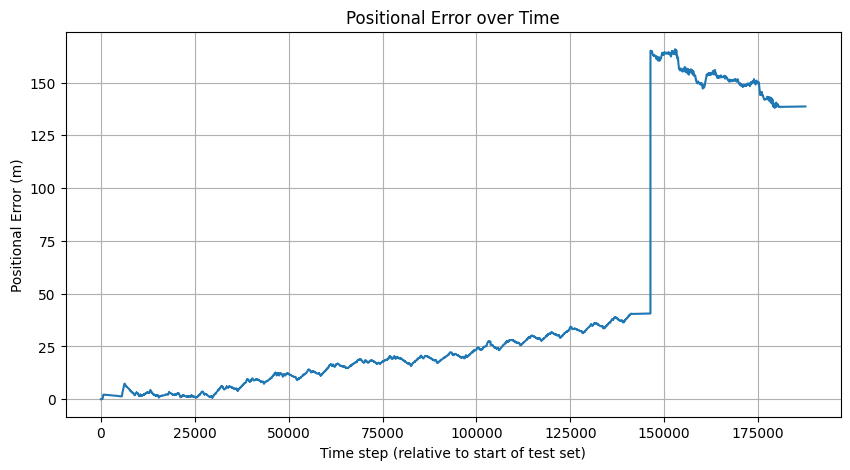

Significant deviation starts around time step: 114628
Corresponding time in minutes: 38.21 minutes


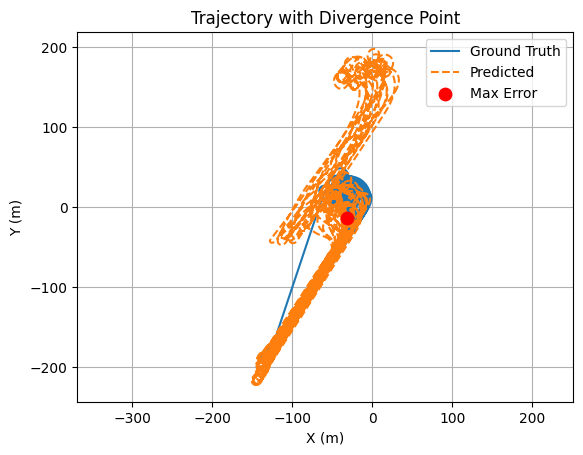

<Figure size 640x480 with 0 Axes>

In [54]:
# positional error (euclidean distance) for the full trajectory
errors = np.sqrt((gt_pos_x - pred_pos_x)**2 + (gt_pos_y - pred_pos_y)**2)

# Plot error over time
plt.figure(figsize=(10, 5))
plt.plot(errors)
plt.xlabel('Time step (relative to start of test set)')
plt.ylabel('Positional Error (m)')
plt.title('Positional Error over Time')
plt.grid(True)
plt.show()

# Find time of significant deviation
error_threshold = 30
deviation_start_index = np.argmax(errors > error_threshold)

if deviation_start_index > 0:
    print(f"Significant deviation starts around time step: {deviation_start_index}")
else:
    print("No significant deviation above the threshold observed.")


corresponding_time = deviation_start_index / (50 * 60)  #in minutes
print(f"Corresponding time in minutes: {corresponding_time:.2f} minutes")

plt.plot(gt_pos_x, gt_pos_y, label='Ground Truth')
plt.plot(pred_pos_x, pred_pos_y, '--', label='Predicted')
plt.scatter(pred_pos_x[deviation_start_index], pred_pos_y[deviation_start_index],color='red',s=80, label='Max Error', zorder=5)
plt.legend()
plt.title('Trajectory with Divergence Point')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.axis('equal')
plt.grid(True)
plt.show()
plt.savefig("Trajectory_with_divergence_point")



In [63]:
num_timesteps = len(test_loader.dataset) 
frequency = 50  # Hz
duration_min = len(test_loader.dataset) / (frequency * 60)
print(f"Duration: {duration_min:.2f} minutes")



Duration: 62.53 minutes
